In [3]:
! export JAX_PLATFORMS=cpu

/gpfs/cfel/group/cmi/common/psi4/psi4conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [4]:
import itertools
import sys

import h5py
import hdfdict
import matplotlib.pyplot as plt
import numpy as np
from jax import config
from py3nj import wigner3j
from rovib.spinrot_xy2 import spin_me_xy2, spinrot_xy2, dipole_xy2
from rovib.symtop import symtop_on_grid_split_angles
from scipy import constants, stats
from scipy.interpolate import RegularGridInterpolator
from scipy.sparse import csr_matrix
from scipy.spatial.transform import Rotation

config.update("jax_enable_x64", True)

KHZ_TO_INVCM = 1.0 / constants.value("speed of light in vacuum") * 10

DEBYE_TO_AU = (
    1e-21
    / constants.value("speed of light in vacuum")
    / constants.value("elementary charge")
    / constants.value("Bohr radius")
)

DEBYE_X_VM_TO_INVCM = (
    constants.value("atomic unit of electric dipole mom.")
    / (constants.value("Planck constant") * constants.value("speed of light in vacuum"))
    / 1e2
    * DEBYE_TO_AU
)

In [5]:
print("Rotational cluster states")

cluster_state_id = {}

with open("h2s_cluster_states_id.txt", "r") as fl:
    for line in fl:
        w = line.split()
        j = [int(w[0 + i * 12]) for i in range(4)]
        id = [int(w[1 + i * 12]) for i in range(4)]
        sym = [w[3 + i * 12] for i in range(4)]
        assert all(j[0] == elem for elem in j), f"Not all J quanta are equal: {j}"
        j_ = j[0]

        if j_ >= 50:
            cluster_state_id[j_] = {}
            for sym_, id_ in zip(sym, id):
                try:
                    cluster_state_id[j_][sym_].append(id_)
                except KeyError:
                    cluster_state_id[j_][sym_] = [id_]
            print(f"J = {j_}, cluster-state IDs: {cluster_state_id[j_]}")

Rotational cluster states
J = 50, cluster-state IDs: {'B2': [277], 'A2': [242], 'B1': [242], 'A1': [280]}
J = 51, cluster-state IDs: {'A1': [267], 'B1': [299], 'B2': [270], 'A2': [299]}
J = 52, cluster-state IDs: {'B2': [324], 'A2': [291], 'A1': [327], 'B1': [291]}
J = 53, cluster-state IDs: {'A1': [316], 'B1': [354], 'B2': [318], 'A2': [353]}
J = 54, cluster-state IDs: {'B2': [385], 'A2': [345], 'A1': [387], 'B1': [344]}
J = 55, cluster-state IDs: {'A1': [371], 'B1': [413], 'A2': [412], 'B2': [373]}
J = 56, cluster-state IDs: {'B2': [447], 'A2': [399], 'B1': [399], 'A1': [450]}
J = 57, cluster-state IDs: {'A1': [432], 'B1': [487], 'B2': [434], 'A2': [486]}
J = 58, cluster-state IDs: {'B2': [520], 'B1': [468], 'A1': [523], 'A2': [469]}
J = 59, cluster-state IDs: {'A1': [503], 'B1': [565], 'A2': [563], 'B2': [505]}
J = 60, cluster-state IDs: {'B1': [542], 'A1': [600], 'A2': [544], 'B2': [599]}


In [37]:
pmax = 20
min_J = 50
max_J = 60

print(f"Read state energies and assignments for J = {min_J}..{max_J}")

with h5py.File(f"h2s_enr_pmax{pmax}.h5", "r") as h5:
    enr = hdfdict.load(h5.require_group("energies"), False)
    qua = hdfdict.load(h5.require_group("quanta"), False)

enr_cluster = {
    J: {sym: enr[str(J)][sym][id] for sym, id in id_J.items()}
    for J, id_J in cluster_state_id.items()
}

qua_cluster = {
    J: {
        sym: np.array(
            [
                [i] + list(elem[0].decode("utf-8").split(","))
                for elem, i in zip(qua[str(J)][sym][id], id)
            ]
        )
        for sym, id in id_J.items()
    }
    for J, id_J in cluster_state_id.items()
}

for J in enr_cluster.keys():
    for sym in enr_cluster[J].keys():
        print(
            f"J = {J}, sym = {sym}, enr.shape = {enr_cluster[J][sym].shape}, "
            + f"qua.shape = {qua_cluster[J][sym].shape}"
        )

print(f"Read spin-rotation and dipole marix elements for J = {min_J}..{max_J}")

sr1_cluster = {}
sr2_cluster = {}
dipole_cluster = {}

for J1, id_J1 in cluster_state_id.items():
    for J2, id_J2 in cluster_state_id.items():
        try:
            filename = f"h2s_me_pmax{pmax}_j{J1}_j{J2}.h5"
            with h5py.File(filename, "r") as h5:
                print(
                    f"read (J1, J2) = {(J1, J2)}, |dJ| = {abs(J1-J2)}, from file {filename}"
                )
                sr1 = hdfdict.load(h5.require_group("spin-rotation-H1"), False)
                sr2 = hdfdict.load(h5.require_group("spin-rotation-H2"), False)
                try:
                    dip = hdfdict.load(h5.require_group("dipole"), False)
                except ValueError:
                    dip = {}

                oper_sym = [{}, {}, {}]
                for sym1, id1 in id_J1.items():
                    for sym2, id2 in id_J2.items():
                        nstates1 = len(enr[str(J1)][sym1])
                        nstates2 = len(enr[str(J2)][sym2])
                        for i, oper in enumerate((sr1, sr2, dip)):
                            if sym1 in oper and sym2 in oper[sym1]:
                                me = oper[sym1][sym2]
                                oper_sym[i][(sym1, sym2)] = (
                                    csr_matrix(
                                        (me["data"], me["indices"], me["indptr"]),
                                        shape=me["shape"],
                                    )
                                    .toarray()
                                    .reshape(nstates1, nstates2, -1)[np.ix_(id1, id2)]
                                )
                sr1_cluster[(J1, J2)] = oper_sym[0]
                sr2_cluster[(J1, J2)] = oper_sym[1]
                dipole_cluster[(J1, J2)] = oper_sym[2]
        except FileNotFoundError:
            pass

Read state energies and assignments for J = 50..60
J = 50, sym = B2, enr.shape = (1,), qua.shape = (1, 10)
J = 50, sym = A2, enr.shape = (1,), qua.shape = (1, 10)
J = 50, sym = B1, enr.shape = (1,), qua.shape = (1, 10)
J = 50, sym = A1, enr.shape = (1,), qua.shape = (1, 10)
J = 51, sym = A1, enr.shape = (1,), qua.shape = (1, 10)
J = 51, sym = B1, enr.shape = (1,), qua.shape = (1, 10)
J = 51, sym = B2, enr.shape = (1,), qua.shape = (1, 10)
J = 51, sym = A2, enr.shape = (1,), qua.shape = (1, 10)
J = 52, sym = B2, enr.shape = (1,), qua.shape = (1, 10)
J = 52, sym = A2, enr.shape = (1,), qua.shape = (1, 10)
J = 52, sym = A1, enr.shape = (1,), qua.shape = (1, 10)
J = 52, sym = B1, enr.shape = (1,), qua.shape = (1, 10)
J = 53, sym = A1, enr.shape = (1,), qua.shape = (1, 10)
J = 53, sym = B1, enr.shape = (1,), qua.shape = (1, 10)
J = 53, sym = B2, enr.shape = (1,), qua.shape = (1, 10)
J = 53, sym = A2, enr.shape = (1,), qua.shape = (1, 10)
J = 54, sym = B2, enr.shape = (1,), qua.shape = (1, 1

In [38]:
min_F = 50
max_F = 60

hyper_enr_cluster = {}
hyper_vec_cluster = {}
hyper_qua_cluster = {}
hyper_shift_cluster = {}
hyper_rov_sym_cluster = {}
hyper_quanta_cluster = {}

for F in range(min_F, max_F + 1):

    J = F

    # comupute hyperfine spin-rotation energies and wavefunctions

    hyper_enr_cluster[F], hyper_vec_cluster[F], hyper_qua_cluster[F], hyper_quanta_cluster[F] = spinrot_xy2(
        F,
        {J: enr_cluster[J]},
        {J: qua_cluster[J]},
        # {},
        # {},
        {(J, J): sr1_cluster[(J, J)]},
        {(J, J): sr2_cluster[(J, J)]},
        spin_states=((0, "B2"), (1, "A1")),
        spins=(0.5, 0.5),
    )

    # print assignments of hypefine cluster states

    hyper_shift_cluster[F] = {sym: [] for sym in hyper_enr_cluster[F].keys()}
    hyper_rov_sym_cluster[F] = {sym: [] for sym in hyper_enr_cluster[F].keys()}
    for sym in hyper_enr_cluster[F].keys():
        for i in range(len(hyper_enr_cluster[F][sym])):
            ind = np.argmax(hyper_vec_cluster[F][sym][:, i] ** 2, axis=0)
            rov_ind = int(hyper_qua_cluster[F][sym][ind][4])
            rov_sym = hyper_qua_cluster[F][sym][ind][1]
            j = int(hyper_qua_cluster[F][sym][ind][0])
            rov_enr = enr[str(j)][rov_sym][rov_ind]
            hyper_shift_cluster[F][sym].append(
                (hyper_enr_cluster[F][sym][i] - rov_enr) / KHZ_TO_INVCM
            )
            hyper_rov_sym_cluster[F][sym].append(rov_sym)
            print(
                f"F = {F}, sym = {sym}, enr = {hyper_enr_cluster[F][sym][i]}, shift (kHz) = {hyper_shift_cluster[F][sym][-1]}, "
                + f"leading quanta = {hyper_qua_cluster[F][sym][ind]}, max(c**2) = {hyper_vec_cluster[F][sym][ind, i]**2}"
            )


F = 50, sym = B1, enr = 24708.81878741142, shift (kHz) = -251.3131280131165, leading quanta = ['50' 'A2' '0' 'B2' '242' 'A2' '50' '0' '1' '2' 'A1' '35' '1' 'A2'], max(c**2) = (0.930430820742419+0j)
F = 50, sym = B1, enr = 24708.81890790879, shift (kHz) = 235.51446431863732, leading quanta = ['50' 'B1' '1' 'A1' '242' 'B1' '50' '0' '1' '2' 'A1' '36' '1' 'B1'], max(c**2) = (0.930430820742419+0j)
F = 50, sym = B2, enr = 24708.818786957007, shift (kHz) = -264.91295520853527, leading quanta = ['50' 'B2' '1' 'A1' '277' 'B2' '50' '1' '0' '2' 'B2' '50' '0' 'A1'], max(c**2) = (0.9315598651704518-0j)
F = 50, sym = B2, enr = 24708.818908370573, shift (kHz) = 249.1142915140561, leading quanta = ['50' 'A1' '0' 'B2' '280' 'A1' '50' '1' '0' '2' 'B2' '45' '0' 'B2'], max(c**2) = (0.9315598651704518+0j)
F = 51, sym = B1, enr = 25447.364236702117, shift (kHz) = -329.4375347059373, leading quanta = ['51' 'B1' '1' 'A1' '299' 'B1' '51' '2' '0' '0' 'A1' '26' '1' 'B1'], max(c**2) = (0.8995880069142649-0j)
F = 

In [39]:
f = 50
dip_me, dip_qua = dipole_xy2(
    {f: hyper_quanta_cluster[f]}, {f: hyper_vec_cluster[f]}, dipole_cluster, m_val=-f
)

In [40]:
print(dip_qua.shape, dip_me.shape)
for q in dip_qua:
    print(q)

(4, 8) (3, 4, 4)
['50' 'B1' '-50' '50' 'A2' '0' 'B2' '1']
['50' 'B1' '-50' '50' 'B1' '1' 'A1' '1']
['50' 'B2' '-50' '50' 'B2' '1' 'A1' '1']
['50' 'B2' '-50' '50' 'A1' '0' 'B2' '1']


(4, 4)
(4, 4)
[[24708.81878696 24708.81878741 24708.81890791 24708.81890837]
 [24708.81878113 24708.81879183 24708.81890349 24708.81891419]
 [24708.81877403 24708.81879471 24708.81890062 24708.81892129]
 [24708.81876615 24708.81879552 24708.81889981 24708.81892917]
 [24708.81875769 24708.81879417 24708.81890116 24708.81893763]
 [24708.81874881 24708.81879081 24708.81890451 24708.81894652]
 [24708.8187396  24708.81878578 24708.81890954 24708.81895573]
 [24708.81873014 24708.81877944 24708.81891589 24708.81896518]
 [24708.81872049 24708.81877212 24708.81892321 24708.81897483]
 [24708.81871069 24708.81876407 24708.81893125 24708.81898463]]
(10,) (10, 4)


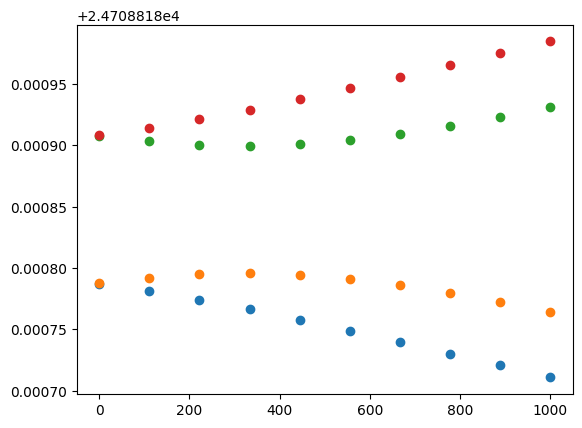

In [41]:
print(dip_me[-1].shape)
field = np.linspace(0, 1000,10)
h0 = np.diag(
    np.concatenate(
        [enr_sym for sym, enr_sym in hyper_enr_cluster[f].items()],
        axis=0,
    )
)
print(h0.shape)

enr = []
for fz in field:
    h = h0 - dip_me[-1] * fz * DEBYE_X_VM_TO_INVCM
    e, v = np.linalg.eigh(h)
    enr.append(e)
enr = np.array(enr)
print(enr)
print(field.shape, enr.shape)
for e in enr.T:
    plt.scatter(field, e)